# Lab 2. Part 4. HAR classification with raw data

Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [18]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
import torch
import torch.nn as nn
from IPython.display import clear_output
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary
from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
matplotlib.rcParams.update({"font.size": 14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [4]:
X_train_with_engineered_features = np.genfromtxt(
    os.path.join("UCI HAR Dataset", "train", "X_train.txt")
)
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array(
    [
        X_train_with_engineered_features[y_train_list.index(l)]
        for l in sorted(list(set(y_train)))
    ]
)

legend_labels = [
    "WALKING",
    "WALKING.UP",
    "WALKING.DOWN",
    "SITTING",
    "STANDING",
    "LAYING",
]
colors_list = ["red", "blue", "green", "orange", "cyan", "magenta"]
mapped_colors = [colors_list[int(i) - 1] for i in y_train]

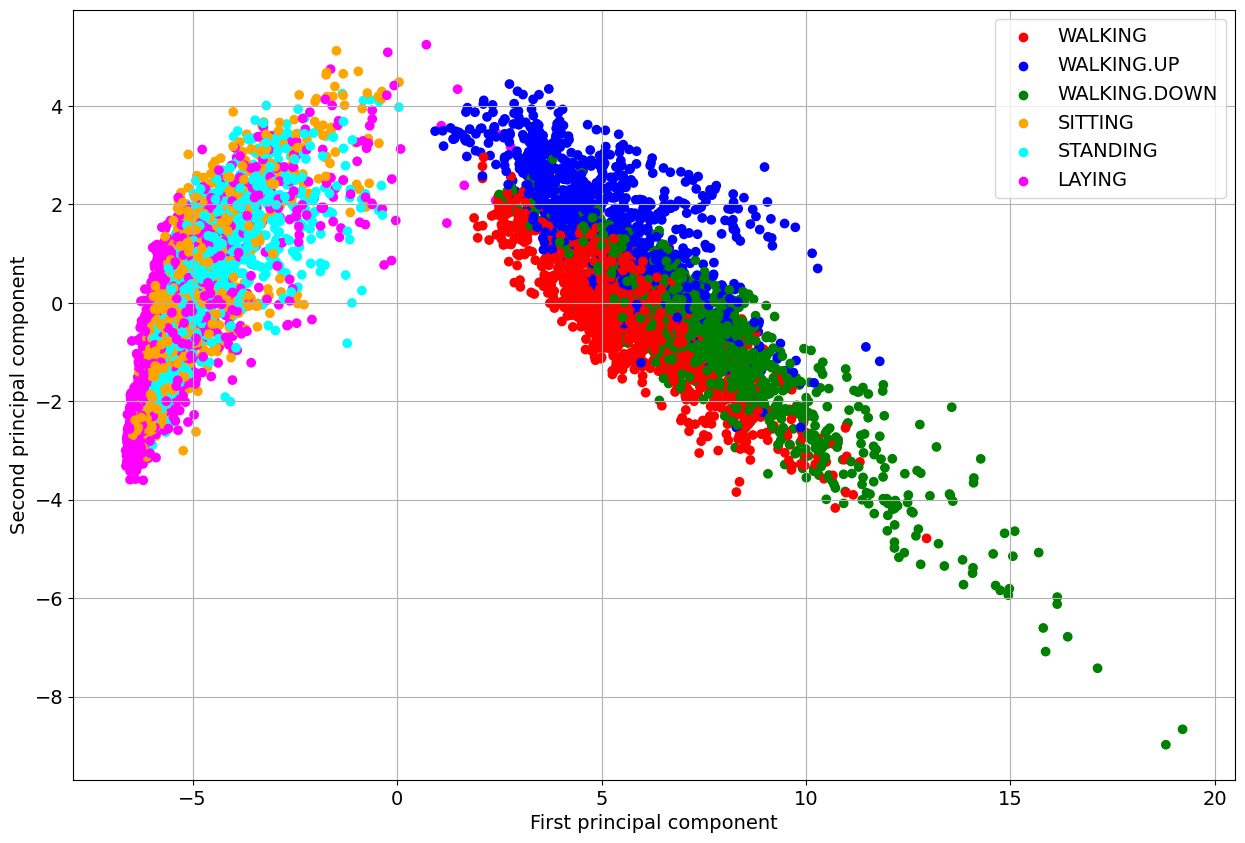

In [5]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15, 10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], x[1], c=colors_list[idx], label=legend_labels[idx])
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.legend()

## Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_",
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING",
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)


def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, "r")
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [
                np.array(serie, dtype=np.float32)
                for serie in [row.replace("  ", " ").strip().split(" ") for row in file]
            ]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))


X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal + "train.txt"])
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal + "test.txt"])
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)


def load_y(y_path):
    file = open(y_path, "r")
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [row.replace("  ", " ").strip().split(" ") for row in file]],
        dtype=np.int32,
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1


y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data

training_data_count = len(
    X_train
)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print(
    "The dataset is therefore properly normalised, as expected, but not yet one-hot encoded."
)

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [8]:
n_classes = len(np.unique(y_test))

In [9]:
list(map(type, [X_train, X_test, y_train, y_test]))

[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64).reshape(-1)
y_test = torch.tensor(y_test, dtype=torch.int64).reshape(-1)

In [11]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [12]:
rand_gen = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(train_dataset, [0.8, 0.2], rand_gen)

In [13]:
list(map(len, [train_dataset, valid_dataset, test_dataset]))

[5882, 1470, 2947]

## Scripts for saving/loading models

In [40]:
def save_checkpoint(model, optimizer, epoch, loss_history, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss_history": loss_history,
    }
    torch.save(checkpoint, path)

In [41]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss_history = checkpoint["loss_history"]
    return epoch, loss_history

## Построение сети и эксперименты

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__

### LSTM

In [29]:
params = {
    "batch_size": 64,
    "seq_len": 128,
    "n_channels": 9,
    "hidden_size": 128,
    "num_layers": 5,
    "dropout": 0.2,
    "n_classes": n_classes,
}

In [30]:
train_loader = DataLoader(train_dataset, params["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_dataset, params["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, params["batch_size"], shuffle=False)

In [31]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=params["n_channels"],
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"],
            batch_first=True,
            dropout=params["dropout"],
        )
        self.linear = nn.Linear(params["hidden_size"], params["n_classes"])

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        logits = self.linear(h[-1])
        return logits

In [32]:
summary(LSTM(), (params["batch_size"], params["seq_len"], params["n_channels"]))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [64, 6]                   --
├─LSTM: 1-1                              [64, 128, 128]            599,552
├─Linear: 1-2                            [64, 6]                   774
Total params: 600,326
Trainable params: 600,326
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.91
Input size (MB): 0.29
Forward/backward pass size (MB): 8.39
Params size (MB): 2.40
Estimated Total Size (MB): 11.09

#### Testing

In [33]:
model = LSTM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [34]:
features, targets = next(iter(train_loader))
logits = model(features.to(device))
print(logits.size(), targets.size())

loss = loss_func(logits, targets)
print(loss)
loss.backward()

torch.Size([64, 6]) torch.Size([64])
tensor(1.7964, grad_fn=<NllLossBackward0>)


#### Training

In [35]:
model = LSTM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [38]:
loss_history = {"train": [], "valid": []}
best_model_params = {"valid_loss": float("inf"), "epoch": -1}

In [39]:
n_epochs = 5

In [192]:
def train(model, n_epochs, loss_history, train_loader, valid_loader, best_model_params):
    for epoch in range(n_epochs):
        model.train()
        train_loss_batches = []
        train_loader_tqdm = tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Training", leave=False
        )
        for features, targets in train_loader_tqdm:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            loss = loss_func(logits, targets)
            train_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_epoch_loss = sum(train_loss_batches) / len(train_dataset)
        loss_history["train"].append(train_epoch_loss)

        model.eval()
        valid_loss_batches = []
        valid_loader_tqdm = tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Validation", leave=False
        )
        with torch.no_grad():
            for features, targets in valid_loader_tqdm:
                features, targets = features.to(device), targets.to(device)
                logits = model(features)
                loss = loss_func(logits, targets)
                valid_loss_batches.append(
                    loss.detach().cpu().numpy() * features.size()[0]
                )
            valid_epoch_loss = sum(valid_loss_batches) / len(valid_dataset)
            loss_history["valid"].append(valid_epoch_loss)

        if (
            sum(valid_loss_batches) / len(valid_dataset)
            < best_model_params["valid_loss"]
        ):
            best_model_params["valid_loss"] = sum(valid_loss_batches) / len(
                valid_dataset
            )
            save_checkpoint(
                model, opt, epoch + 1, loss_history, "lab02_part04_lstm.pth"
            )

        clear_output(wait=True)
        plt.figure(figsize=(12, 6))

        plt.plot(loss_history["train"], label="Train Loss")
        plt.plot(loss_history["valid"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss - Epoch {epoch + 1}/{n_epochs}")
        plt.legend()
        plt.grid(True)

        plt.show()

        print(
            f"Epoch {epoch + 1}/{n_epochs}: "
            f"Train Loss = {train_epoch_loss:.3f}, Validation Loss = {valid_epoch_loss:.3f}"
        )

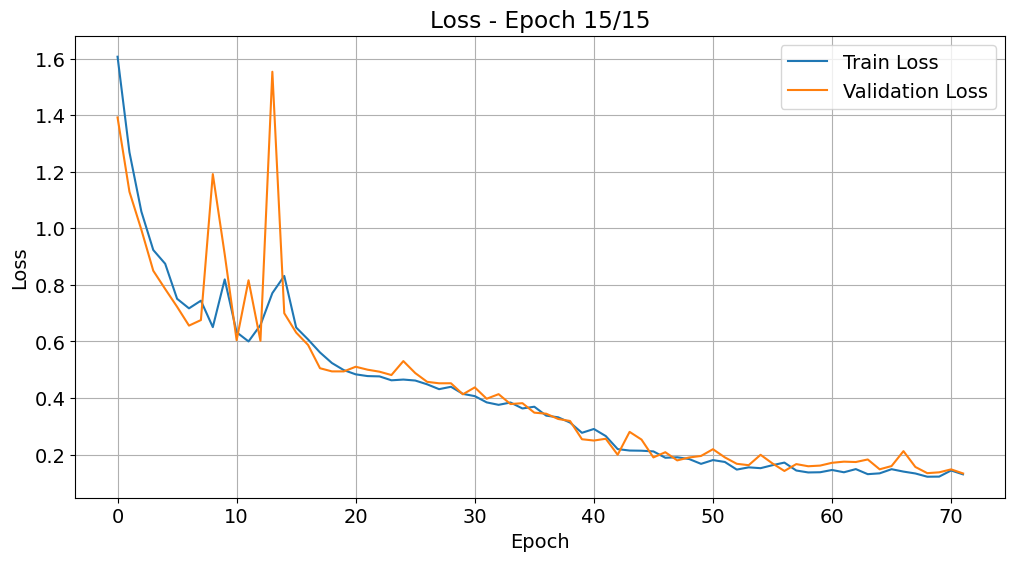

Epoch 15/15: Train Loss = 0.130, Validation Loss = 0.133


In [199]:
train(model, n_epochs, loss_history, train_loader, valid_loader, best_model_params)

In [195]:
def test(model, test_loader):
    model.eval()
    corr_preds = 0
    total_preds = 0
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for features, targets in test_loader_tqdm:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, pred_labels = torch.max(logits, dim=1)
            corr_preds += (pred_labels == targets).sum().item()
            total_preds += targets.size(0)

    acc = corr_preds / total_preds
    print(f"Test Accuracy: {acc * 100:.3f}%")

In [200]:
test(model=model, test_loader=test_loader)

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Test Accuracy: 90.872%
